# Find hotels optimally located to all tourist attractions in Rome

## Table of contents
* [Introduction](#introduction)
* [Business Problem](#business)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Many people like to spend their vacation sightseeing in cities such as Rome, Paris, London, etc. These are huge cities with a large number of attractions. The first thing a tourist faces: Where is the best place to live to see everything?

## Business Problem <a name="business"></a>

A vacation and money are not endless! For a week, or even less, I want to see as much as possible and not waste time on unnecessary movements. Let's create a tool that will help the tourist to suggest hotels from which will be closer to the sights of interest to him. Key factors in choosing a hotel:

- the location of the hotel is optimal for the desired attractions
- the hotel has free rooms
- the price per room does not exceed the indicated amount

To simplify the task, we assume that the tourist walks only on foot. If possible, we will try to solve the problem taking into account the movement by metro and the time for sightseeing.

## Data <a name="data"></a>

We will consider Rome, where all the roads lead :) 

### User defined: List of tourist attractions
As a basic, let's take a list of attractions in Rome from Wikipedia 
https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Rome

From this list we will make a few randomly deleting sight.

### Coodrinates of attractions and hotels

Foursquare API will help list the hotels and showplaces
https://developer.foursquare.com/docs/api-reference/venues/search/

### Hotel's room availability
Real-time pricing and availability can be derived from Booking.com API https://developers.booking.com/api/commercial/index.html?version=2.7&page_url=usage-information

Using the API - Booking.com Developers API

In [18]:
# import libraries
from bs4 import BeautifulSoup
import requests
import re
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import cluster

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


The sight coordinates can be derived via Foursquare API or the wiki page about the interesting place. The values from wiki (column Link) will be used in Foursquare API say nothing about that place.

In [19]:
# Function of wiki page parsing to take the latitude, longitude
def get_coordinates_from_wiki(url):
    wiki = requests.get(url)
    soup = BeautifulSoup(wiki.text, "html.parser")
    # take the values from the spans with coordinate classes
    latitude = soup.find('span', class_='latitude')
    longitude = soup.find('span', class_='longitude')

    latitude = latitude.text
    longitude = longitude.text

    pattern = re.compile(u"(?P<hours>[0-9]*)°(?P<minutes>[0-9]*)′(?P<seconds>[0-9]*)″")
    m = pattern.match(latitude)
    r = m.groupdict()
    latitude = int(r["hours"]) + int(r["minutes"]) / 60.0 + int(r['seconds']) / 3600.0
    m = pattern.match(longitude)
    r = m.groupdict()
    longitude = int(r["hours"]) + int(r["minutes"]) / 60.0 + int(r['seconds']) / 3600.0

    return latitude, longitude

Foursquare API can return too many objects for the search request with name only. For example, really we can get a restarant 'Colosseum' insteasd of Colosseum as historical object. Look at the categories page.  https://developer.foursquare.com/docs/build-with-foursquare/categories/
Seems that two categories are suitable: Monument / Landmark = 4bf58dd8d48988d12d941735 and Historic Site = 4deefb944765f83613cdba6e. We will use them in the followng code:

In [20]:
CLIENT_ID = 'XO2XUS0HVMYTFKX0FTUC0NSCUWS1SSS5ULD3JT5JMK5UN1LL'  # your Foursquare ID
CLIENT_SECRET = 'G4F2R4KKKE5QS3JXO5SO10M3KU3TESOJCZBKFCLE4BLXHJ44'  # your Foursquare Secret
VERSION = '20180605'  # Foursquare API version
LIMIT = 3  # A default Foursquare API limit value

roma_lat = 41.89193
roma_lon = 12.51133

def get_coordinates(name, link):
    url1 = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}&categoryId=4bf58dd8d48988d12d941735,4deefb944765f83613cdba6e".format(
        CLIENT_ID, CLIENT_SECRET, VERSION, roma_lat, roma_lon, 30000, name, LIMIT)
    url2 = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}".format(
        CLIENT_ID, CLIENT_SECRET, VERSION, roma_lat, roma_lon, 30000, name, LIMIT)
    results = requests.get(url1).json()
    if len(results['response']['venues']) == 0:
        results = requests.get(url2).json()
    if len(results['response']['venues']) > 0:
        sight_data = results['response']['venues'][0]
        latitude = sight_data['location']['lat']
        longitude = sight_data['location']['lng']
        #qualified_name= sight_data['name']
    else:
        latitude, longitude = get_coordinates_from_wiki(link)

    return latitude, longitude

In [21]:
# create the tourist attractions table
# define the dataframe columns
column_names = ['Name', 'Types', 'Link', 'Latitude', 'Longitude'] 

# instantiate the dataframe
sights = pd.DataFrame(columns=column_names)

# Get the list of tourist attractions from Wikipedia https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Rom

url = 'https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Rome'
wiki = requests.get(url)

soup = BeautifulSoup(wiki.text, "html.parser")
tables = soup.find_all('table')
for table in tables:
    for rows in table.find_all('tr'):
        cells = rows.find_all('td')
        if len(cells) > 0:
            if hasattr(cells[1].a, 'attrs'):
                link = cells[1].a.attrs['href']
            else:
                link = None
            name = (cells[1].text).replace('St ', 'St. ')
            wiki_link =  ('https://en.wikipedia.org/{0}'.format(link))
            latitude, longitude = get_coordinates( name, wiki_link )
            cell = {'Types': cells[0].text, 'Name': name,
                    'Period': cells[2].text, 'Link': wiki_link, 'Latitude':latitude, 'Longitude':longitude}            
            sights = sights.append( cell, ignore_index=True)

Let's take a look at the first item in this list.

In [22]:
sights.head()

,Name,Types,Link,Latitude,Longitude,Period
0,St. Peter's Basilica,Basilica,https://en.wikipedia.org//wiki/St_Peter%27s_Ba...,41.902133,12.453582,16th century
1,Archbasilica of Saint John Lateran,"Basilica, Cathedral",https://en.wikipedia.org//wiki/Archbasilica_of...,41.885833,12.505556,16th century
2,Basilica di Santa Maria Maggiore,Basilica,https://en.wikipedia.org//wiki/Basilica_di_San...,41.897629,12.498429,"ancient Rome, 15th–16th century"
3,Basilica of Saint Paul Outside the Walls,Basilica,https://en.wikipedia.org//wiki/Basilica_of_Sai...,41.902429,12.520164,"Romanesque, medieval"
4,Basilica di San Lorenzo fuori le Mura,Basilica,https://en.wikipedia.org//wiki/Basilica_di_San...,41.902429,12.520164,"Paleochristian, romanesque"


In [23]:
sights.shape

(41, 6)

Let's visualize Roma with sights

In [24]:
# create map of Roma using latitude and longitude values
map_roma = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(sights['Latitude'], sights['Longitude'], sights['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_roma)  
    
map_roma

## Methodology <a name="methodology"></a>

In the first step, we have collected the required data:  tourist attractions with coordinates.

The second step in our analysis will be observing the sights on the map and creating clusters of locations using k-means clustering. Why the k-means is good for us? K-means requires the input of cluster numbers.  If we have a certain number of days for holidays in Rome and if we feel the power to change hotels several times then the predefined number of clusters very suitable for us. The center of clusters will be taken into account as optimal places for booking hotels there. It will minimize our moving around the city. We can stay in one hotel near a cluster centroid, sightseeing all attractions of the cluster, move to another hotel to the next cluster centroid, etc.  

In the final step, we will focus on searching the hotels near the cluster's centroids.
 

## Analysis <a name="analysis"></a>


Immagine that we ready to change hotels three times. Set k=3 for K-means clustering

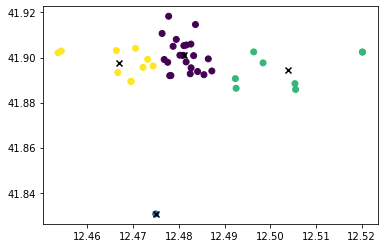

(array([[12.48120912, 41.90105848],
        [12.474951  , 41.830582  ],
        [12.50387778, 41.89452999],
        [12.46702465, 41.89756446]]),
 array([3, 2, 2, 2, 2, 3, 3, 0, 0, 2, 3, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 3, 3, 2, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3, 3, 2, 0, 0]))

In [25]:
# K-means clustering based on longitude-latitude
def k_means_sights_distribution(kclusters=7):    
    from sklearn.cluster import KMeans
    from sklearn import cluster

    kmeans = cluster.KMeans(kclusters)
    kmeans.fit(sights[['Longitude', 'Latitude']])
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    plt.scatter(sights['Longitude'], sights['Latitude'], c=labels)
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='black')
    plt.show()
    
    return centroids, labels
k_means_sights_distribution(4)

One point on the south, 'Esposizione Universale Roma' placed too far from others and highlighted to the separated cluster. Obviously, I'm not ready to change the hotel for the one sightseeing only. We can drive one time for the one sight. 

Let's look at the situation when we don't know exactly how much days we will stay in Roma. In this case, optimal numners of hotel changing = optimal number of clusters by Elbow method: draw the curve of the distortion and number of clusters.

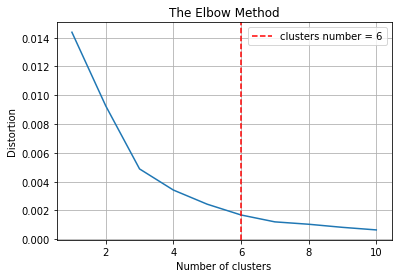

In [26]:
# Iterate K-Means algorithm several time for different number of clusters
from sklearn.cluster import KMeans
from sklearn import cluster
sights_coordinates = sights[["Latitude","Longitude"]]
max_clusters_number = 10
distortions = [] 
for i in range(1, max_clusters_number+1):
    if len(sights_coordinates) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(sights_coordinates)
       distortions.append(model.inertia_)
## best cluster number: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="clusters number = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

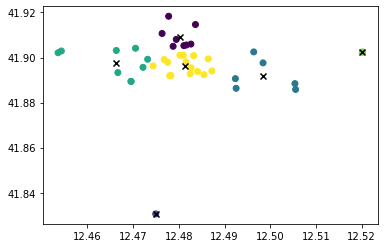

In [27]:
optimal_k=k
centroids, labels = k_means_sights_distribution(optimal_k)

Put the sights and centroids on the real map.

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(optimal_k)
ys = [i + x + (i*x)**2 for i in range(optimal_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
# add centroids
for i in range(len(centroids)):
    label = folium.Popup("Centroid", parse_html=True)
    folium.CircleMarker(  [ centroids[i][1],centroids[i][0]],  radius=10, popup=label,  color='#ff0000', fill=True, fill_color='#FFFFFF', fill_opacity=0.9).add_to(map_clusters) 

# add tourist attractions
for lat, lon, label, cluster in zip(sights['Latitude'], sights['Longitude'], sights['Name'], labels):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


       
map_clusters

Find the hotels near the centroids by the Foursquare API. Limits the distance from the centroid in 300m and count of hotels = 3 for each centroid.

In [29]:
hotels = {}
hotels_column_names = ['Name', 'Cluster', 'Address', 'Latitude', 'Longitude']
hotels_data = pd.DataFrame(columns=hotels_column_names)

for i in range(len(centroids)):
    center = centroids[i]
    url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4bf58dd8d48988d1fa931735".format(
        CLIENT_ID, CLIENT_SECRET, VERSION, center[1], center[0], 300, 3)
    results = requests.get(url).json()
    data = results['response']['venues']
    if len(data) < 1:
        print('Not found a hotel')
    for x in data:
        if not (x['id'] in hotels):
            x['centroid'] = i
            hotels.setdefault(x['id'], x)
            if not ('address' in x['location']):
                print('Hotel without the address! ', x['name'], 'Cluster {}'.format(i))
            else:
                cell = {'Name': x['name'], 'Cluster': x['centroid'], 'Address': x['location']['address'],
                        'Latitude': x['location']['lat'], 'Longitude': x['location']['lng']}
                hotels_data = hotels_data.append(cell, ignore_index=True)
        else:
            print('hotel is already added', x)

Hotel without the address!  Relais Mediterraneum Hotel Cluster 1
Hotel without the address!  Sabelli House Cluster 4
Hotel without the address!  Otivm Hotel Cluster 5


Foursquare returned some hotels without the address string! Carefully list all the hotels. Mey be there is no hotels in some clusters.

In [30]:
hotels_data


,Name,Cluster,Address,Latitude,Longitude
0,Caffè Canova-Tadolini,0,"Via del Babuino, 150A/B",41.907839,12.479691
1,Piazza di Spagna Comfort Rooms,0,"Via Del Babuino, 70, Spagna/Rome",41.907770,12.479890
2,Hotel de Russie,0,Via del Babuino 9,41.910126,12.477775
3,Hotel dei Congressi,1,Viale Shakespeare 29,41.830384,12.472957
4,Adagio Apartahotel Rome Garden,1,via dell'arte 5,41.833030,12.476181
5,Mercure Roma Centro Colosseo,2,Via Labicana 144,41.890060,12.498122
6,Wow Colosseum,2,Via Poliziano 8,41.892423,12.501245
7,Chroma Hotel,2,Via Merulana 43,41.894554,12.500831
8,DOM,3,"Via Giulia, 131",41.897324,12.467160
9,Hotel Rinascimento,3,Via del Pellegrino 122,41.897407,12.468486


Add the hotels to the map

In [31]:
# create map with hotels and sights
map_hotels = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(optimal_k)
ys = [i + x + (i*x)**2 for i in range(optimal_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
# add centroids
for i in range(len(centroids)):
    label = folium.Popup("Centroid", parse_html=True)
    folium.CircleMarker(  [ centroids[i][1],centroids[i][0]],  radius=10, popup=label,  color='#ff0000', fill=True, fill_color='#FFFFFF', fill_opacity=0.9).add_to(map_hotels) 

# add hotels
for lat, lon, label, cluster in zip(hotels_data['Latitude'], hotels_data['Longitude'], hotels_data['Name'], hotels_data['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(  [lat, lon],  radius=5, popup=label,  color='#AA2211', fill=True, fill_color='#FFFFFF', fill_opacity=0.9).add_to(map_hotels) 

# add tourist attractions
for lat, lon, label, cluster in zip(sights['Latitude'], sights['Longitude'], sights['Name'], labels):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_hotels)


       
map_hotels

Immitate the booking hotels: keep one hotel for each cluster, remove the unused hotel, set booked as centroids, recalculate the clusters.

In [32]:
booked_hotels=hotels_data.drop_duplicates('Cluster', keep='last').reset_index(drop=True)


In [33]:
booked_hotels

,Name,Cluster,Address,Latitude,Longitude
0,Hotel de Russie,0,Via del Babuino 9,41.910126,12.477775
1,Adagio Apartahotel Rome Garden,1,via dell'arte 5,41.833030,12.476181
2,Chroma Hotel,2,Via Merulana 43,41.894554,12.500831
3,Orsa Maggiore Roma,3,Via di San Francesco di Sales,41.894640,12.465631
4,Roma Scout Center,4,largo dello scautismo,41.899197,12.518395
5,Guesthouse I Tre Moschettieri,5,Vicolo Sciarra 61,41.899394,12.481511


Rebuild clusters where the hotels are centroids. Build the distances table between each hotel and each sight and then keep only records with minimal distance to a hotel for each sight.

In [34]:
# build the sight-hotel distances table
distances_column_names = ['Sight', 'Hotel', 'Distance', 'Latitude', 'Longitude', 'Cluster']
distances = pd.DataFrame(columns=distances_column_names)

for i, s in sights.iterrows():
    for j, h in booked_hotels.iterrows():
        d = np.sqrt(np.square(s['Latitude'] - h['Latitude']) + np.square(s['Longitude'] - h['Longitude']))
        row = {'Sight': s['Name'], 'Hotel': h['Name'], 'Distance':d, 'Latitude': s['Latitude'], 'Longitude':s['Longitude'], 'Cluster': h['Cluster'] }
        distances = distances.append(row, ignore_index=True)
distances.head()

,Sight,Hotel,Distance,Latitude,Longitude,Cluster
0,St. Peter's Basilica,Hotel de Russie,0.025479,41.902133,12.453582,0
1,St. Peter's Basilica,Adagio Apartahotel Rome Garden,0.072705,41.902133,12.453582,1
2,St. Peter's Basilica,Chroma Hotel,0.047852,41.902133,12.453582,2
3,St. Peter's Basilica,Orsa Maggiore Roma,0.014189,41.902133,12.453582,3
4,St. Peter's Basilica,Roma Scout Center,0.064879,41.902133,12.453582,4


In [ ]:
sights_distribution = distances.sort_values('Distance').drop_duplicates(['Sight'],keep='first').reset_index(drop=True)
sights_distribution

Display the sights clustered by selected hotels

In [37]:
# create map with hotels and sights
map_booked = folium.Map(location=[latitude, longitude], zoom_start=12)

# add hotels = centroids
for lat, lon, label, cluster in zip(booked_hotels['Latitude'], booked_hotels['Longitude'], booked_hotels['Name'], booked_hotels['Name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(  [lat, lon],  radius=10, popup=label,  color='#ff0000', fill=True, fill_color='#FFFFFF', fill_opacity=0.9).add_to(map_booked) 

# add tourist attractions
for lat, lon, label, cluster in zip(sights_distribution['Latitude'], sights_distribution['Longitude'], sights_distribution['Sight'], sights_distribution['Cluster']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_booked)


       
map_booked

We see that some sights get another clusters after the setup the hotels as cluster centers. Compare the last map and the previous.

## Results and Discussion <a name="results"></a>

During analysis, we found 41 tourist attractions in Rome recommended in Wikipedia.K-means method grouped them to cluster for optimizing movement around the city. The number of clusters with lowset distortion = 7. One sight is out of common sight distribution character. Look at the south region on the map with markers. Esposizione Universale Roma placed far from others. Then we asked Foursquare API to return  3 nearest hotels for the center of each cluster. It was strange that some hotels returned without address, we ignore them. Hotels added to the map give us food for thought. Some hotels have such big distance to the center of clusters that we should move the cluster’s center to the selected hotel coordinates and recalculate. For example, if we choose ‘Orsa Maggiore Roma’ hotel then 'Piazza Navona' and 'Palazzo di Giustizia ("Palazzaccio")' jump to other clusters. So we need to rebuild the clusters after hotel booking and get the result map with distributed turist attractions distributed among hotel zones.
To simplify the task, we did not take into account the real way from sight to sight. The street paths can be very complex. Also, each tourist has a self-view for the speed of observing. For example, one can spend a day in Colosseum. For another, it can take an hour.

## Conclusion <a name="conclusion"></a>

This solution is suitable in two cases when you are arriving as a tourist to view a city. First: you agree with changing several times hotels to minimize the time of walking among attractions. In this case, you predefine the number of clusters.  Second: you want to group tourist attractions for a view by portions. You will use the number of the cluster with the lowest distortion and the map of clusters for creating a plan of tour.  